# Combined 3D Models & Error-Time Graph

In [7]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt

## Initializations & Functions

In [8]:
# intialize parameters
Lx, Ly, Lz = 1, 2, 3  # dim of 3D box
Nx, Ny, Nz = 4, 8, 12  # num of grid points in each direction
dx, dy, dz = Lx / Nx, Ly / Ny, Lz / Nz
N = 500  # num of ions
D = 5.13e-6  # diffusion coefficient (sodium)

# random neighbor selection in 3D
def select_random_neighbor(x, y, z):
    neighbors = [
        ((x - 1) % Nx, y, z), ((x + 1) % Nx, y, z),
        (x, (y - 1) % Ny, z), (x, (y + 1) % Ny, z),
        (x, y, (z - 1) % Nz), (x, y, (z + 1) % Nz)
    ]
    return random.choice(neighbors)

# diffusion function for discrete model (single neighbors attempt)
def diffuse(grid, ion_positions, pmove):
    new_grid = np.copy(grid)
    new_ion_positions = np.copy(ion_positions)
    for i in range(N):
        x, y, z = ion_positions[i]
        if grid[x, y, z] != 0:
            nbr_x, nbr_y, nbr_z = select_random_neighbor(x, y, z)
            if grid[nbr_x, nbr_y, nbr_z] == 0:
                if pmove > random.random():
                    new_grid[nbr_x, nbr_y, nbr_z] += 1
                    new_grid[x, y, z] -= 1
                    new_ion_positions[i] = (nbr_x, nbr_y, nbr_z)
    return new_grid, new_ion_positions

In [9]:
# Laplacian matrix for continuous model
def laplacian(dx, dy, dz, Nx, Ny, Nz):
    k = Nx * Ny * Nz
    L = np.zeros((k, k))
    for i in range(k):
        L[i, i] = -6 / dx**2  # Central point
        if (i + 1) % Nx != 0:  # Right neighbor
            L[i, i + 1] = 1 / dx**2
        if i % Nx != 0:  # Left neighbor
            L[i, i - 1] = 1 / dx**2
        if (i + Nx) < k:  # Top neighbor
            L[i, i + Nx] = 1 / dy**2
        if (i - Nx) >= 0:  # Bottom neighbor
            L[i, i - Nx] = 1 / dy**2
        if (i + Nx * Ny) < k:  # Front neighbor
            L[i, i + Nx * Ny] = 1 / dz**2
        if (i - Nx * Ny) >= 0:  # Back neighbor
            L[i, i - Nx * Ny] = 1 / dz**2
    return L

## Everything Function
- basically same as 2D everything function (changed it up a little for efficiency like max_time_steps, return errors only)
- runs models
- track errors over time 

In [11]:
def run_simulation(dt, max_time_steps=2000):

    pmove = (D * 3 * dt) / dx**2  # movement probability

    # initialize 3D grid and ions (discrete model)
    discrete_model = np.zeros((Nx, Ny, Nz), dtype=int)
    ion_x = np.mod(np.random.normal(0.3 * Lx, 0.5, N), Lx)
    ion_y = np.mod(np.random.normal(0.3 * Ly, 0.5, N), Ly)
    ion_z = np.mod(np.random.normal(0.3 * Lz, 0.5, N), Lz)
    ion_i = np.ceil(ion_x / dx).astype(int)
    ion_j = np.ceil(ion_y / dy).astype(int)
    ion_k = np.ceil(ion_z / dz).astype(int)
    for i in range(N):
        discrete_model[ion_i[i] % Nx, ion_j[i] % Ny, ion_k[i] % Nz] += 1
    ion_positions = np.column_stack((ion_i % Nx, ion_j % Ny, ion_k % Nz))

    # initialize phi (cont model) to match grid
    phi = np.array(discrete_model, dtype=float)

    # create Laplacian matrices for continuous model
    k = Nx * Ny * Nz
    I = np.identity(k)
    L = laplacian(dx, dy, dz, Nx, Ny, Nz)
    A = I - ((dt * D) / 2) * L
    B = I + ((dt * D) / 2) * L
    vecphi = phi.flatten(order="F")  # flatten phi for matrix operations

    # track error over time
    errors = []
    x_vals = [0]  # starting time is 0 ms
    y_vals = [0]  # MSE at t=0 is 0

    for t in range(1, max_time_steps):

        # advance continuous model
        vecphi = np.linalg.solve(A, np.dot(B, vecphi))
        cont_model = vecphi.reshape((Nx, Ny, Nz), order="F")

        # advance discrete model
        discrete_model, ion_positions = diffuse(discrete_model, ion_positions, pmove)

        # compute MSE
        mse = np.mean((discrete_model - cont_model) ** 2)
        errors.append(mse)

        # Append time (in ms) and MSE
        x_vals.append(t * dt)  # mult by dt to convert to ms
        y_vals.append(mse)

    return x_vals, y_vals

## Try different dt's attempts (manually, WIP)

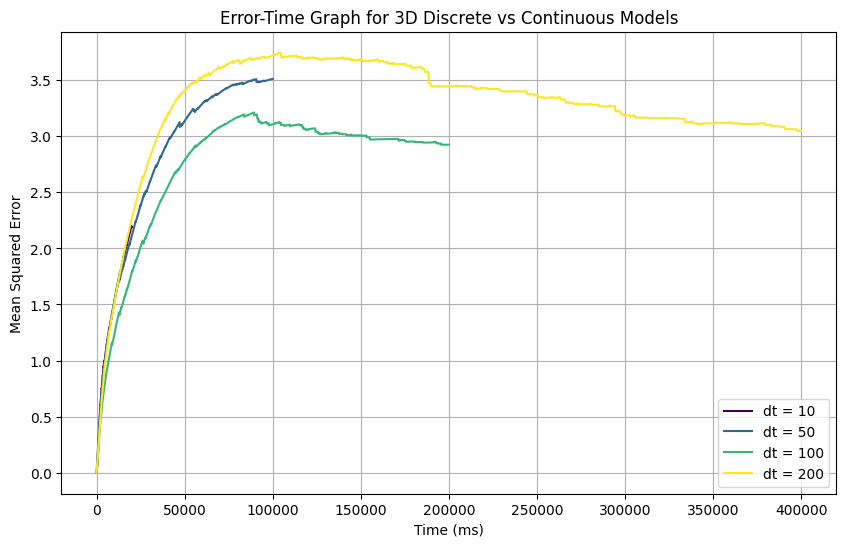

In [12]:
dts = [10, 50, 100, 200]
max_time_steps = 2000
results = {}

for dt in dts:
    results[dt] = run_simulation(dt, max_time_steps=max_time_steps)

# plot error-time graph
plt.figure(figsize=(10, 6))
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(dts)))  # viridis color map
for i, (dt, errors) in enumerate(results.items()):
    x_vals, y_vals = errors
    plt.plot(x_vals, y_vals, label=f"dt = {dt}", color=viridis_colors[i])

plt.xlabel("Time (ms)")
plt.ylabel("Mean Squared Error")
plt.title("Error-Time Graph for 3D Discrete vs Continuous Models")
plt.legend()
plt.grid(True)
plt.show()

- longer max time steps? -> 2500?
- can try different dts: <10 and >200

Running simulation for dt = 5
Running simulation for dt = 10
Running simulation for dt = 200
Running simulation for dt = 500


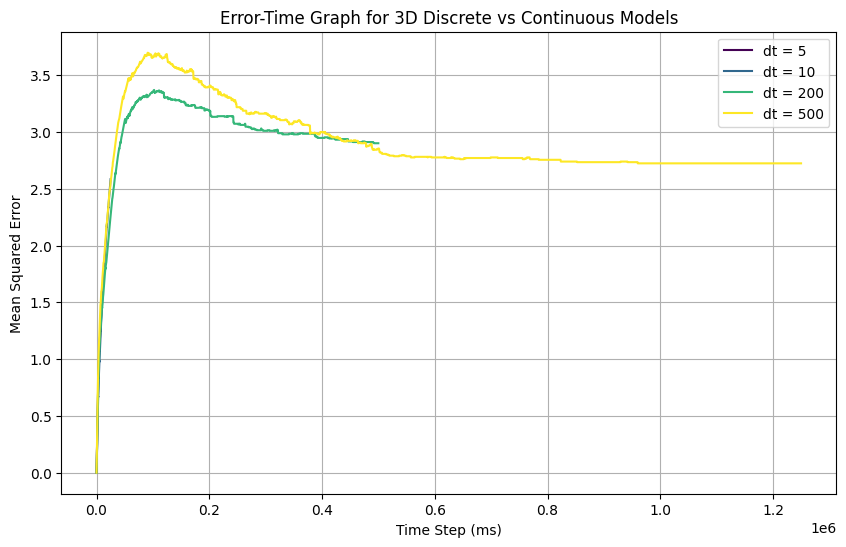

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming run_simulation is already defined and working correctly

# List of dt values to test
dts = [5, 10, 200, 500]
max_time_steps = 2500
results = {}

# Run simulations for multiple dt values
for dt in dts:
    print(f"Running simulation for dt = {dt}")
    x_vals, errors = run_simulation(dt, max_time_steps=max_time_steps)

    # Store results
    results[dt] = {
        'x_vals': x_vals,
        'errors': errors
    }

# Plot error-time graph
plt.figure(figsize=(10, 6))
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(dts)))  # Use viridis color map
for i, (dt, result) in enumerate(results.items()):
    plt.plot(result['x_vals'], result['errors'], label=f"dt = {dt}", color=viridis_colors[i])

plt.xlabel("Time Step (ms)")
plt.ylabel("Mean Squared Error")
plt.title("Error-Time Graph for 3D Discrete vs Continuous Models")
plt.legend()
plt.grid(True)
plt.show()


- larger dt's seem to be doing better   
    - try 1000, 1250
- increase max time steps: 3000

... continued on ...

Running simulation for dt = 7000
Running simulation for dt = 7500
Running simulation for dt = 7750
Running simulation for dt = 8000


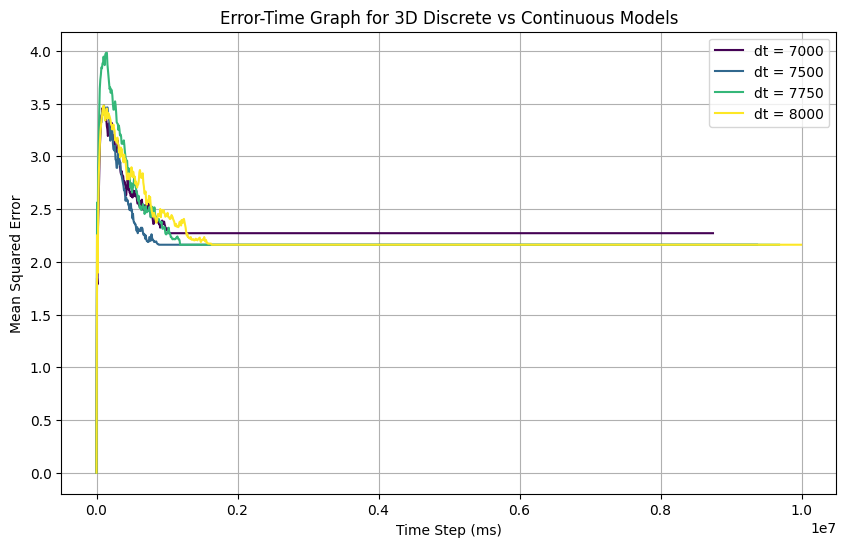

In [25]:
dts = [7000, 7500, 7750, 8000]
max_time_steps = 1250
results = {}

# run simulations for multiple dt values
for dt in dts:
    print(f"Running simulation for dt = {dt}")
    x_vals, errors = run_simulation(dt, max_time_steps=max_time_steps)

    # store results
    results[dt] = {
        'x_vals': x_vals,
        'errors': errors
    }

# plot error-time graph
plt.figure(figsize=(10, 6))
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(dts)))  # Use viridis color map
for i, (dt, result) in enumerate(results.items()):
    plt.plot(result['x_vals'], result['errors'], label=f"dt = {dt}", color=viridis_colors[i])

plt.xlabel("Time Step (ms)")
plt.ylabel("Mean Squared Error")
plt.title("Error-Time Graph for 3D Discrete vs Continuous Models")
plt.legend()
plt.grid(True)
plt.show()


best so far
- try dt closer between 7750 and 8000

## Try Hyperparameter Tuning for dt's

### lowest mean or final MSE

In [19]:
import numpy as np

def grid_search_dt(dt_values, max_time_steps=2000):
    best_dt = None
    best_mse = float('inf')
    best_x_vals = None
    best_y_vals = None

    for dt in dt_values:
        print(f"Running simulation for dt = {dt}")

        # run simulation with the current dt
        x_vals, y_vals = run_simulation(dt, max_time_steps)

        # Calculate the final MSE or mean MSE
        mse = np.mean(y_vals)

        # Update the best parameters if the current one is better
        if mse < best_mse:
            best_mse = mse
            best_dt = dt
            best_x_vals = x_vals
            best_y_vals = y_vals

    print(f"Best dt: {best_dt} with MSE: {best_mse}")
    return best_dt, best_mse, best_x_vals, best_y_vals

Running simulation for dt = 10.0
Running simulation for dt = 21.544346900318832
Running simulation for dt = 46.41588833612777
Running simulation for dt = 100.0
Running simulation for dt = 215.44346900318823
Running simulation for dt = 464.15888336127773
Running simulation for dt = 1000.0
Running simulation for dt = 2154.4346900318824
Running simulation for dt = 4641.588833612777
Running simulation for dt = 10000.0
Best dt: 10.0 with MSE: 1.2370312074012964


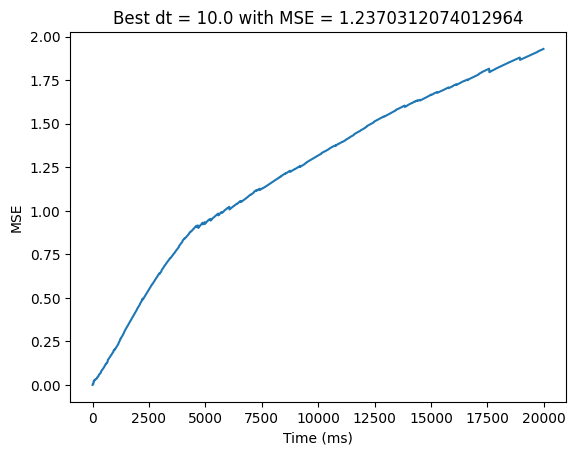

In [20]:
# define the range of dt values to search over
dt_values = np.logspace(np.log10(10), np.log10(10000), num=10)  # log scale from 10 to 10,000 with 10 values

# run grid search
best_dt, best_mse, best_x_vals, best_y_vals = grid_search_dt(dt_values)

# plot the results
import matplotlib.pyplot as plt

plt.plot(best_x_vals, best_y_vals)
plt.xlabel('Time (ms)')
plt.ylabel('MSE')
plt.title(f"Best dt = {best_dt} with MSE = {best_mse}")
plt.show()


### dt with quickest decrease? (look at derivative)

In [21]:
def grid_search(dt_range, max_time_steps=2000):
    best_dt = None
    best_rate_of_change = None

    for dt in dt_range:
        x_vals, y_vals = run_simulation(dt, max_time_steps)
        
        # Calculate the rate of change of MSE
        error_changes = np.diff(y_vals)  # Differences in MSE over time
        rate_of_change = np.mean(error_changes)  # Average rate of change

        # Update the best dt if the rate of decrease is better
        if best_rate_of_change is None or rate_of_change < best_rate_of_change:
            best_rate_of_change = rate_of_change
            best_dt = dt

    return best_dt, best_rate_of_change

# Define range of dt values (on a larger scale)
dt_range = np.logspace(np.log10(10), np.log10(100000), num=10)  # Log scale for dt

# Perform grid search for the best dt
best_dt, best_rate_of_change = grid_search(dt_range)

print(f"Best dt: {best_dt}, Best rate of error decrease: {best_rate_of_change}")

Best dt: 12915.496650148827, Best rate of error decrease: 0.0010526096381524095
